<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import time
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)
import os

from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
pth1 = 'taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [4]:
state = 888

In [5]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


**Целевой признак**
* **num_orders** - количество заказов

In [6]:
print(f'Размер данных: {df.shape}')

Размер данных: (26496, 1)


In [7]:
#создадим копию
df_full = df.copy()

In [8]:
# взглянем на пропуски
df.isna().sum()

num_orders    0
dtype: int64

In [9]:
# взглянем на дубликаты
df.index.duplicated().sum()

0

In [10]:
#проверим упорядочен ли наш index
print(df.index.is_monotonic)

True


In [11]:
#Измененим интервал со значениями до 1 часа, при этом агрегированным значением ряда выберем сумму.
df = df.resample('1H').sum()

In [12]:
 df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

In [13]:
#анализ периода за который предоставили данные:
df.index.min(), df.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

Данные предоставленны за период с 01 марта до 31 августа (включительно) - то есть за полгода

 **Необработанный временной ряд**

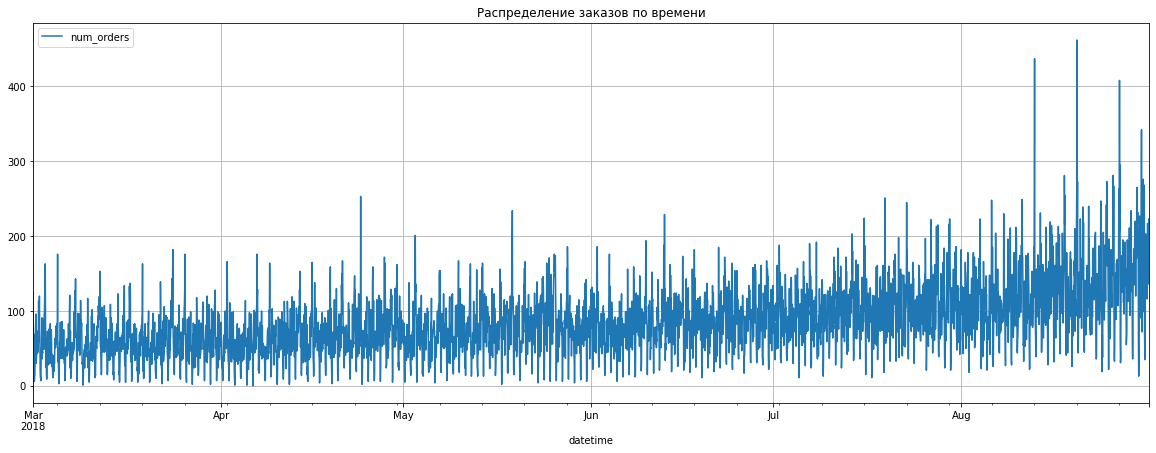

In [14]:
df.plot(title='Распределение заказов по времени', grid=True);

Не особо понятно. Проведём декомпозицию и выведем графики трендов и сезонности.

**Тренды и сезонность**

In [15]:
decomposed = seasonal_decompose(df)

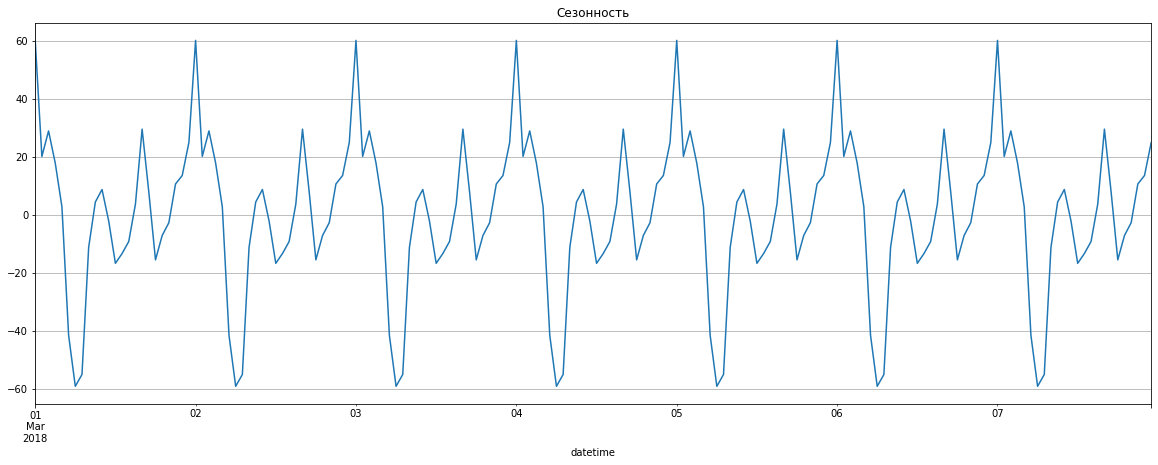

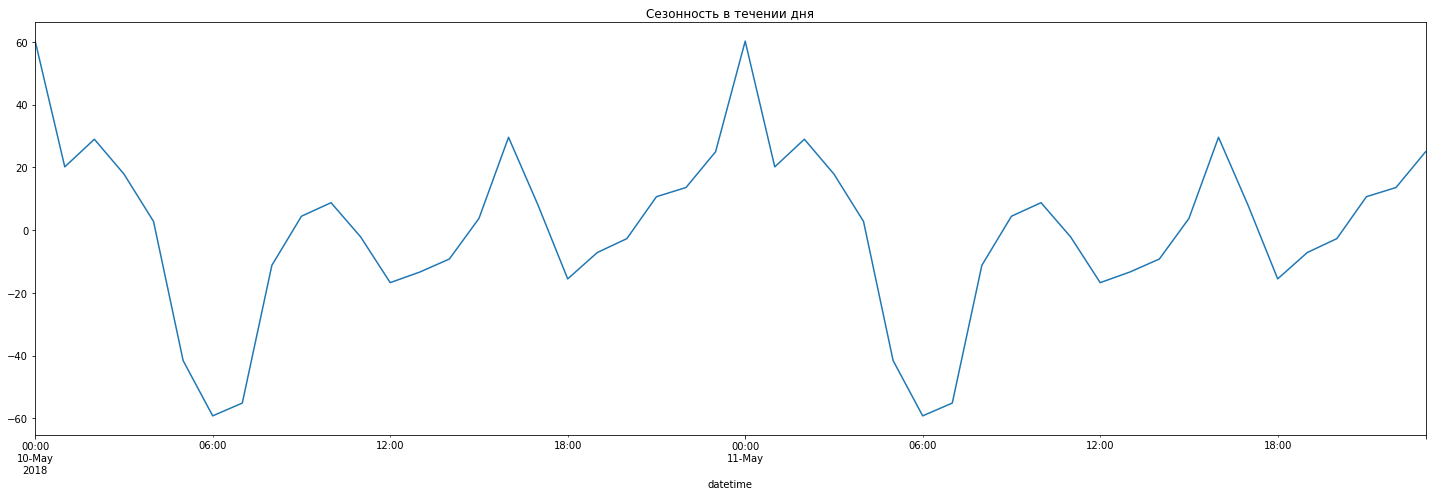

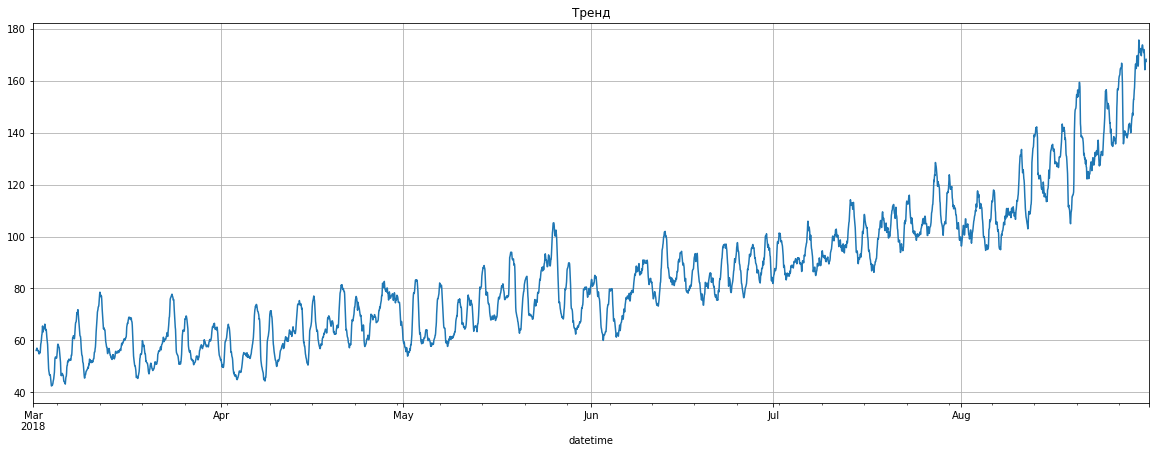

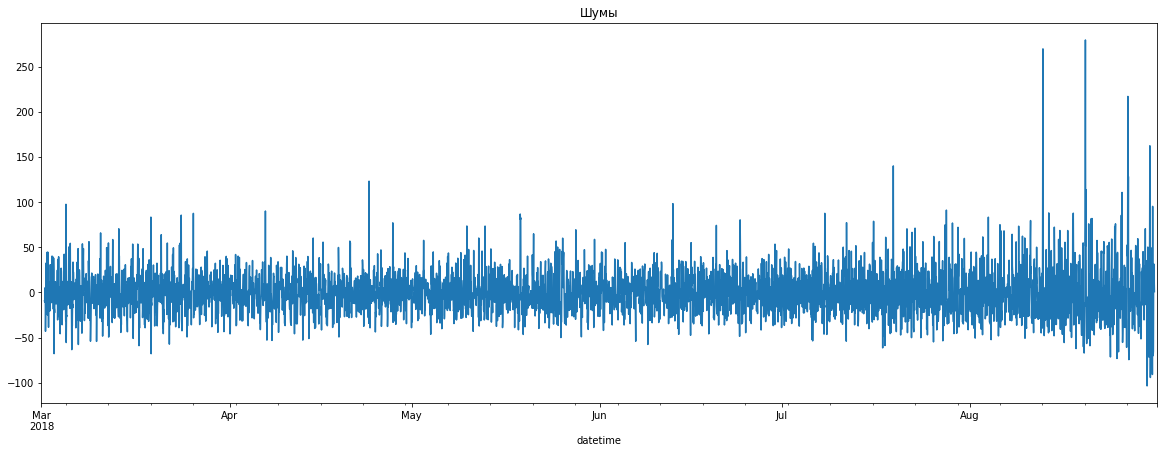

In [16]:
decomposed.seasonal.head(24*7).plot(title='Сезонность', grid=True)
plt.show()
decomposed.seasonal['2018-05-10':'2018-05-11'].plot(ax=plt.gca())
plt.title('Сезонность в течении дня')
plt.tight_layout()
plt.show()
decomposed.trend.plot(title='Тренд', grid=True)
plt.show()
decomposed.resid.plot(title='Шумы');

**Вывод**

* Предоставленный датасет имеет данные за пол года: с марта по август.
* Данные имеют суточную сезонность - в ночное время заказов мало, а в веченее наоборот  - большое количесвто заказов:
* По графику видно, что данные имеют восходящий тренд, возможно это связано с приходом лета и начала сезона отпусков.

## Обучение

In [17]:
#Создадим признаки
def make_features(dataframe, max_lag, rolling_mean_size):
    data = dataframe.copy(deep=True)
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data


In [18]:
df = make_features(df, 168, 10)

In [19]:
df.head(10)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,3,8,15.0,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#Разделим нашу таблилцу на обучающую и тестовые выборку:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [21]:
#Определим признаки и целевой признак у обучающей и тестовой выборк
x = train.drop(['num_orders'], axis=1)
y = train['num_orders']

x_test = test.drop(['num_orders'],axis=1)
y_test = test['num_orders']

In [22]:
#Проверим правильно ли расположены временные даннные
display(train.tail(3))
display(test.head(3))

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 11:00:00,144,0,11,156.0,137.0,91.0,39.0,66.0,83.0,143.0,...,104.0,85.0,133.0,204.0,117.0,98.0,104.0,87.0,131.0,159.3
2018-08-13 12:00:00,92,0,12,144.0,156.0,137.0,91.0,39.0,66.0,83.0,...,67.0,104.0,85.0,133.0,204.0,117.0,98.0,104.0,87.0,146.4
2018-08-13 13:00:00,119,0,13,92.0,144.0,156.0,137.0,91.0,39.0,66.0,...,98.0,67.0,104.0,85.0,133.0,204.0,117.0,98.0,104.0,111.9


,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,102,0,14,119.0,92.0,144.0,156.0,137.0,91.0,39.0,...,101.0,98.0,67.0,104.0,85.0,133.0,204.0,117.0,98.0,107.0
2018-08-13 15:00:00,175,0,15,102.0,119.0,92.0,144.0,156.0,137.0,91.0,...,119.0,101.0,98.0,67.0,104.0,85.0,133.0,204.0,117.0,102.9
2018-08-13 16:00:00,144,0,16,175.0,102.0,119.0,92.0,144.0,156.0,137.0,...,156.0,119.0,101.0,98.0,67.0,104.0,85.0,133.0,204.0,112.1


In [23]:
#Размеры обучающей и тестовой выборки
print('Размер обучающей выборки: {} объектов, {} признаков'.format(x.shape[0], x.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(x_test.shape[0], x_test.shape[1]))

Размер обучающей выборки: 3806 объектов, 171 признаков
Размер тестовой выборки: 442 объектов, 171 признаков


**Обучение**

In [24]:
tscv = TimeSeriesSplit(n_splits=5)

def model_analysis(model, parameters, x, y):
    start_time = time.time()
    grid = GridSearchCV(model, param_grid = parameters,
                        cv=tscv,
                        n_jobs=-1,
                        scoring = 'neg_root_mean_squared_error')
    grid.fit(x, y)
    first_time = time.time() - start_time
    start_time = time.time()
    predict = grid.predict(x)
    second_time = time.time() - start_time
    stat_data = [first_time, second_time, grid.best_score_]
    return stat_data, grid

**LinearRegression**

In [25]:
lr = LinearRegression()
param_lr = {}

In [26]:
model_lr, grid_lr = model_analysis(lr, param_lr, x, y)

In [27]:
grid_lr

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearRegression(), n_jobs=-1, param_grid={},
             scoring='neg_root_mean_squared_error')

In [28]:
model_lr

[3.682936668395996, 0.11616301536560059, -22.627523499578512]

 **Ridge**

In [29]:
ridge = Ridge()


In [30]:
param_ridge = {
    'alpha': np.arange(0, 0.21, 0.01),
    'random_state' : [state]
}

In [31]:
model_ridge, grid_ridge = model_analysis(ridge, param_ridge, x, y)

In [32]:
grid_ridge

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
                         'random_state': [888]},
             scoring='neg_root_mean_squared_error')

In [33]:
model_ridge

[36.14596366882324, 0.09465217590332031, -22.52912480202953]

**LightGBM** 

Данная модель у меня быстро считает исключительно в Гугл Коллаб. В Jupyterhub постоянно падает даже без подбора гипер параметров. В дальнейшем планирую отказаться от этой модели в проектах, т.к. она мне второй проект делает мозг(((.

In [34]:
lgbm = LGBMRegressor()

In [35]:
param_lgbm = {
    'n_estimators': [25,80,220],
    'learning_rate': [0.12],
    'random_state' : [state]
}

In [ ]:
model_lgbm, grid_lgbm = model_analysis(lgbm, param_lgbm, x, y)

In [ ]:
grid_lgbm

In [ ]:
model_lgbm

**Random Forest**

In [ ]:
forest = RandomForestRegressor()

In [ ]:
param_forest = {
    'n_estimators': [80, 120, 100],
    'max_depth': [13, 22, 33],
    'max_features': [3, 6, 9],
    'random_state' : [state]
}

In [ ]:
model_forest, grid_forest = model_analysis(forest, param_forest, x, y)

In [ ]:
grid_forest

In [ ]:
model_forest

**Результаты**

In [ ]:
#для Гугл колаб
# results_df =  analysis_data = pd.DataFrame([model_lr, model_ridge, model_lgbm, model_forest],
#              columns=['Learning Time', 'Predicting Time', 'RMSE'],
#                       index=['LinearRegression','Ridge','LightGBM','Random Forest'])

In [ ]:
#для Jupyterhub
results_df =  analysis_data = pd.DataFrame([model_lr, model_ridge, model_forest],
             columns=['Learning Time', 'Predicting Time', 'RMSE'],
                      index=['LinearRegression','Ridge','Random Forest'])

In [ ]:
results_df

Модель LightGBM у меня работает только в ГуглКолаб(((.

**Вывод**

Все модели показали достойный результат, но стоит выделить это модели `LightGBM` и `Random Forest`.

Основным кретерием у заказчика является показатель `RMSE`, то лучшей моделью является `Random Forest`. Заказчик не выдвигал требования по скорости обучения и предсказания, эти данные были созданы больше для наглядности и на итоговое решение никак не влияют.

## Тестирование

In [ ]:
forest_test = grid_forest.predict(x_test)

In [ ]:
print('rmse', np.sqrt(mean_squared_error(y_test, forest_test)))

In [ ]:
graph = y_test.copy()
predictions_taxi = pd.DataFrame(data = forest_test, columns = ['predictions'], index = x_test.index.copy())
df_out = pd.merge(graph, predictions_taxi, how = 'left', left_index = True, right_index = True)
df_out['predictions'] = df_out['predictions'].astype('int64')
df_out['2018-08-15':'2018-08-17'].plot()
plt.show()

**Вывод**

Как видно по графику, наша модель достаточно хорошо попадает в реальные заказы. Конечно есть погрешности, которые можно исправить. Но в целом дает хороший результат.